# Arkouda Lightning Tutorial

## Connect to the Arkouda server

In [35]:
import arkouda as ak
ak.connect('localhost', 5555) 

connected to arkouda server tcp://*:5555


In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import gc

## Read Parquet Taxi Cab Data

In [37]:
start = time.time()

data = ak.read_parquet('/lus/scratch/mcdonald/data20-24/*', has_non_float_nulls=True)

stop = time.time()
print(f"Read Parquet files execution time: {stop - start:.2f} seconds")

Read Parquet files execution time: 1.10 seconds


In [38]:
data = ak.DataFrame(data)
print(f"Total amount of data: {(data.size * 4)/(1024*1024):.2f} GBs")

Total amount of data: 341.77 GBs


In [39]:
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,1576684350000000,1576684479000000,N,1.0,264,264,5.0,0.00,3.50,0.50,0.5,0.01,0.00,0.3,4.81,1.0,1.0,0.00
1,2,1577839558000000,1577840199000000,N,5.0,66,65,2.0,1.28,20.00,0.00,0.0,4.06,0.00,0.3,24.36,1.0,2.0,0.00
2,2,1577839298000000,1577839969000000,N,1.0,181,228,1.0,2.47,10.50,0.50,0.5,3.54,0.00,0.3,15.34,1.0,1.0,0.00
3,1,1577839966000000,1577841261000000,N,1.0,129,263,2.0,6.30,21.00,3.25,0.5,0.00,0.00,0.3,25.05,2.0,1.0,2.75
4,1,1577837997000000,1577838656000000,N,1.0,210,150,1.0,2.30,10.00,0.50,0.5,0.00,0.00,0.3,11.30,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715447,2,1717194000000000,1717194840000000,,0.0,166,239,0.0,2.26,17.22,0.00,0.0,4.09,0.00,1.0,25.06,0.0,0.0,NaN
4715448,2,1717193280000000,1717194120000000,,0.0,149,89,0.0,2.75,17.39,0.00,0.0,0.89,0.00,1.0,19.28,0.0,0.0,NaN
4715449,2,1717194240000000,1717195560000000,,0.0,89,97,0.0,4.29,30.30,0.00,0.0,1.54,0.00,1.0,32.84,0.0,0.0,NaN
4715450,2,1717198034000000,1717199535000000,,0.0,80,61,0.0,3.53,23.02,0.00,0.0,0.00,0.00,1.0,24.02,0.0,0.0,NaN


## Data Exploration

More information on the Arkouda API can be found at: https://bears-r-us.github.io/arkouda/

### Descriptive statistics

In [40]:
def describe(x):
    fmt = 'mean: {}\nstd: {}\nmin: {}\nmax: {}'
    if x.dtype == ak.float64:
        fmt = fmt.format(*['{:.2f}' for _ in range(4)])
    print(fmt.format(x.mean(), x.std(), x.min(), x.max()))

In [41]:
describe(data['fare_amount'])

mean: 17.65
std: 15.58
min: -500.00
max: 4003.00


#### Histogram

In [42]:
import numpy as np
from matplotlib import pyplot as plt

def hist(x, bins, log=True):
    assert bins > 0
    h, bins = ak.histogram(x, bins)
    plt.bar(bins[:-1].to_ndarray(), h.to_ndarray(), width=bins[1]-bins[0])
    if log:
        plt.yscale('log')

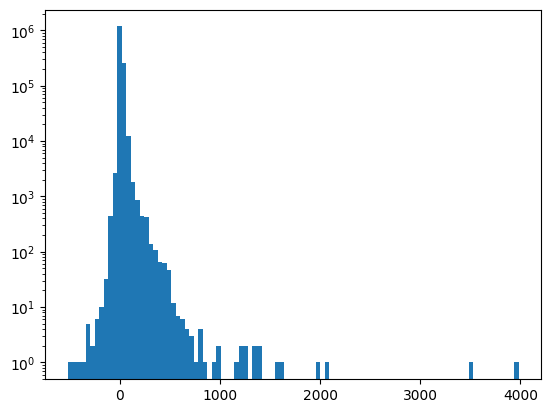

In [43]:
hist(data['fare_amount'], 100)

# Taxi Zone Lookup Table

In [44]:
import pandas as pd

def cvt_to_string(v):
    try:
        if v == '':
            return 'N/A'
        else:
            return str(v)
    except:
        return 'N/A'

cvt = {'Borough':cvt_to_string, 'Zone':cvt_to_string, 'service zone':cvt_to_string}
tzlut = pd.read_csv('./taxi_zone_lookup.csv', converters=cvt)

top_row = pd.DataFrame({'LocationID': [0], 'Borough': ['N/A'], 'service_zone':['N/A']})
tzlut = pd.concat([top_row, tzlut]).reset_index(drop=True)

In [45]:
tzlut

,LocationID,Borough,service_zone,Zone
0,0,N/A,N/A,NaN
1,1,EWR,EWR,Newark Airport
2,2,Queens,Boro Zone,Jamaica Bay
3,3,Bronx,Boro Zone,Allerton/Pelham Gardens
4,4,Manhattan,Yellow Zone,Alphabet City
...,...,...,...,...
261,261,Manhattan,Yellow Zone,World Trade Center
262,262,Manhattan,Yellow Zone,Yorkville East
263,263,Manhattan,Yellow Zone,Yorkville West
264,264,Unknown,NaN,N/A


#### Convert Pandas DF to Arkouda DF

In [46]:
def ak_create_from_df(df):
    akdict = {}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=str)
        else:
            akdict[cname] = ak.from_series(df[cname])
    return ak.DataFrame(akdict)

In [47]:
aktzlut = ak_create_from_df(tzlut)

#### Apply Lookup Table

In [49]:
data['PUBorough'] = aktzlut['Borough'][data['PULocationID']]
data['DOBorough'] = aktzlut['Borough'][data['DOLocationID']]

In [50]:
data['PUZone'] = aktzlut['Zone'][data['PULocationID']]
data['DOZone'] = aktzlut['Zone'][data['DOLocationID']]

In [51]:
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PUBorough,DOBorough,PUZone,DOZone
0,2,1576684350000000,1576684479000000,N,1.0,264,264,5.0,0.00,3.50,...,0.00,0.3,4.81,1.0,1.0,0.00,Unknown,Unknown,N/A,N/A
1,2,1577839558000000,1577840199000000,N,5.0,66,65,2.0,1.28,20.00,...,0.00,0.3,24.36,1.0,2.0,0.00,Brooklyn,Brooklyn,DUMBO/Vinegar Hill,Downtown Brooklyn/MetroTech
2,2,1577839298000000,1577839969000000,N,1.0,181,228,1.0,2.47,10.50,...,0.00,0.3,15.34,1.0,1.0,0.00,Brooklyn,Brooklyn,Park Slope,Sunset Park West
3,1,1577839966000000,1577841261000000,N,1.0,129,263,2.0,6.30,21.00,...,0.00,0.3,25.05,2.0,1.0,2.75,Queens,Manhattan,Jackson Heights,Yorkville West
4,1,1577837997000000,1577838656000000,N,1.0,210,150,1.0,2.30,10.00,...,0.00,0.3,11.30,1.0,1.0,0.00,Brooklyn,Brooklyn,Sheepshead Bay,Manhattan Beach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715447,2,1717194000000000,1717194840000000,,0.0,166,239,0.0,2.26,17.22,...,0.00,1.0,25.06,0.0,0.0,NaN,Manhattan,Manhattan,Morningside Heights,Upper West Side South
4715448,2,1717193280000000,1717194120000000,,0.0,149,89,0.0,2.75,17.39,...,0.00,1.0,19.28,0.0,0.0,NaN,Brooklyn,Brooklyn,Madison,Flatbush/Ditmas Park
4715449,2,1717194240000000,1717195560000000,,0.0,89,97,0.0,4.29,30.30,...,0.00,1.0,32.84,0.0,0.0,NaN,Brooklyn,Brooklyn,Flatbush/Ditmas Park,Fort Greene
4715450,2,1717198034000000,1717199535000000,,0.0,80,61,0.0,3.53,23.02,...,0.00,1.0,24.02,0.0,0.0,NaN,Brooklyn,Brooklyn,East Williamsburg,Crown Heights North


#### GroupBy: Construct a Graph

In [52]:
start = time.time()

byloc = ak.GroupBy([data['PULocationID'], data['DOLocationID']])

stop = time.time()
print(f"Total amount of data: {(data['PULocationID'].size*4*2)/(1024*1024):.2f} GBs")
print(f"GroupBy execution time: {stop - start}")

Total amount of data: 35.98 GBs
GroupBy execution time: 0.7710151672363281


#### Broadcast: Find Rides with Anomalous Fares

In [54]:
start = time.time()

_, mf = byloc.mean(data['fare_amount'])

stop = time.time()
print(f"Mean execution time: {stop - start:.2f} seconds")

Mean execution time: 0.52 seconds


In [56]:
start = time.time()

(u, v), w = byloc.size()

stop = time.time()
print(f"Size execution time: {stop - start:.2f} seconds")

Size execution time: 0.21 seconds


In [57]:
start = time.time()

sf = (byloc.sum(data['fare_amount']**2)[1] / w) - mf**2

stop = time.time()
print(f"Standard dev execution time: {stop - start:.2f} seconds")

Standard dev execution time: 1.36 seconds


In [58]:
data['fare_mean'] = byloc.broadcast(mf, permute=True)
data['fare_std'] = byloc.broadcast(sf, permute=True)

In [59]:
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,total_amount,payment_type,trip_type,congestion_surcharge,PUBorough,DOBorough,PUZone,DOZone,fare_mean,fare_std
0,2,1576684350000000,1576684479000000,N,1.0,264,264,5.0,0.00,3.50,...,4.81,1.0,1.0,0.00,Unknown,Unknown,N/A,N/A,15.295274,400.452589
1,2,1577839558000000,1577840199000000,N,5.0,66,65,2.0,1.28,20.00,...,24.36,1.0,2.0,0.00,Brooklyn,Brooklyn,DUMBO/Vinegar Hill,Downtown Brooklyn/MetroTech,9.955618,57.630741
2,2,1577839298000000,1577839969000000,N,1.0,181,228,1.0,2.47,10.50,...,15.34,1.0,1.0,0.00,Brooklyn,Brooklyn,Park Slope,Sunset Park West,11.006069,27.964486
3,1,1577839966000000,1577841261000000,N,1.0,129,263,2.0,6.30,21.00,...,25.05,2.0,1.0,2.75,Queens,Manhattan,Jackson Heights,Yorkville West,25.826456,35.200625
4,1,1577837997000000,1577838656000000,N,1.0,210,150,1.0,2.30,10.00,...,11.30,1.0,1.0,0.00,Brooklyn,Brooklyn,Sheepshead Bay,Manhattan Beach,9.988694,81.963628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715447,2,1717194000000000,1717194840000000,,0.0,166,239,0.0,2.26,17.22,...,25.06,0.0,0.0,NaN,Manhattan,Manhattan,Morningside Heights,Upper West Side South,11.139098,6.675093
4715448,2,1717193280000000,1717194120000000,,0.0,149,89,0.0,2.75,17.39,...,19.28,0.0,0.0,NaN,Brooklyn,Brooklyn,Madison,Flatbush/Ditmas Park,19.385789,79.544782
4715449,2,1717194240000000,1717195560000000,,0.0,89,97,0.0,4.29,30.30,...,32.84,0.0,0.0,NaN,Brooklyn,Brooklyn,Flatbush/Ditmas Park,Fort Greene,21.133783,22.408988
4715450,2,1717198034000000,1717199535000000,,0.0,80,61,0.0,3.53,23.02,...,24.02,0.0,0.0,NaN,Brooklyn,Brooklyn,East Williamsburg,Crown Heights North,18.485541,65.267435


In [60]:
data['fare_z'] = (data['fare_amount'] - data['fare_mean']) / (data['fare_std'] + 1)

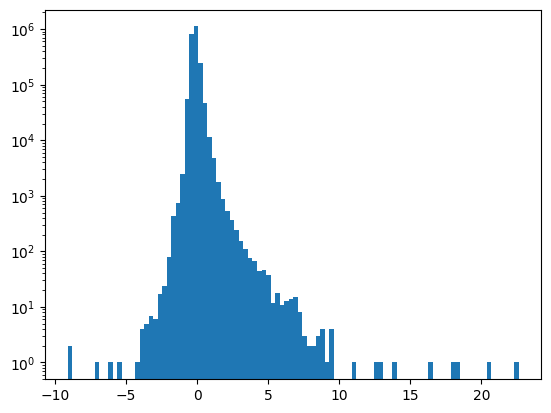

In [61]:
hist(data['fare_z'], 100)

#### Bring Small Result Set Back to Pandas

In [62]:
exorbitant = (data['fare_z'] > 2)
exdf = pd.DataFrame({k: v[exorbitant].to_ndarray() for k, v in data.items()})
print(f"Number of exorbitant rows: {int(exdf.size/26)}")

Number of exorbitant rows: 2156


In [63]:
exdf.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,PUBorough,DOBorough,PUZone,DOZone,fare_mean,fare_std,fare_z
0,2,1577848050000000,1577848541000000,N,5.0,33,231,2.0,2.99,79.9,...,2.0,1.0,2.75,Brooklyn,Manhattan,Brooklyn Heights,TriBeCa/Civic Center,12.707102,18.476910,3.449875
1,2,1577896505000000,1577904627000000,N,5.0,152,244,1.0,0.00,60.0,...,1.0,2.0,0.00,Manhattan,Manhattan,Manhattanville,Washington Heights South,10.667072,21.161010,2.226114
2,2,1577961132000000,1577963692000000,N,1.0,75,74,1.0,5.94,28.0,...,2.0,1.0,0.00,Manhattan,Manhattan,East Harlem South,East Harlem North,7.332101,7.766012,2.357731
3,1,1578044828000000,1578049792000000,N,3.0,41,138,1.0,36.80,124.0,...,1.0,1.0,0.00,Manhattan,Queens,Central Harlem,LaGuardia Airport,27.778583,36.256336,2.582686
4,2,1578123188000000,1578124707000000,N,1.0,75,74,1.0,13.19,36.5,...,2.0,1.0,0.00,Manhattan,Manhattan,East Harlem South,East Harlem North,7.332101,7.766012,3.327385


In [64]:
worst = data['fare_z'].argmax()
{k:v[worst] for k, v in data.items()}

{'VendorID': 2,
 'lpep_pickup_datetime': 1582137378000000,
 'lpep_dropoff_datetime': 1582187426000000,
 'store_and_fwd_flag': 'N',
 'RatecodeID': 1.0,
 'PULocationID': 41,
 'DOLocationID': 74,
 'passenger_count': 1.0,
 'trip_distance': 4.9,
 'fare_amount': 421.5,
 'extra': 1.0,
 'mta_tax': 0.5,
 'tip_amount': 0.0,
 'tolls_amount': 0.0,
 'improvement_surcharge': 0.3,
 'total_amount': 423.3,
 'payment_type': 2.0,
 'trip_type': 1.0,
 'congestion_surcharge': 0.0,
 'PUBorough': 'Manhattan',
 'DOBorough': 'Manhattan',
 'PUZone': 'Central Harlem',
 'DOZone': 'East Harlem North',
 'fare_mean': 7.500949797810408,
 'fare_std': 17.1738841062676,
 'fare_z': 22.779888315641585}